# Machine Learnning with Google Earth Engine (GEE)
Machine Learning (ML) is a powerful technique for analyzing Earth Observation data. The Google Earth Engine (GEE) has built-in capabilities to allow users to build and use ML models for common scenarios with easy-to-use APIs.

A common ML task is to classify the pixels in satellite imagery into two or more categories. The approach is useful for Land Use Land Cover mapping and other popular applications. In the GEE API it is possible to train models. However, sometimes the GEE API has it's limits and you want use GEE results with other APIs. In that case it is common to export images outside GEE and train there, where other python libraries are available.

Identifying areas of human settlement is a large area of focus in Earth Observation and many other disciplines.

The Global Human Settlement Layer (GHSL) dataset is a useful resource for understanding areas of settlement and happily for our purposes, it is available in the GEE catalogue.

The dataset we are particularly interested in is the GHSL “Settlement Grid” layer. The settlement grids in this dataset have been generated via the GHSL built-up areas and population grids, which are themselves derived from Landsat image collections and other sources and these layers are also available on GEE.

The GHSL dataset will be used to get the labels for different regions. We would like to predict the land use based on RGB bands, NIR bands, red edge bands, and average Day/Night Band(DNB) radiance values. The average DNB radiance will be fetched from the *VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1* dataset. The other bands will be fetched from the Sentinel-2 dataset.

Read the following resources if you like further reading on the GEE.

- https://earthengine.google.com/
- https://www.sciencedirect.com/science/article/pii/S0034425717302900



In [1]:
!pip install geemap rasterio -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s eta 0:00:00


# Setup

If you have already run this setup (for e.g as part of Exercise 5_02), please reuse the private key. 
Otherwise, follow the steps at https://docs.google.com/document/d/13SKLn_mqhlaRc1gElr4kmBrkw6KZPeqDDW3AjcTr8YY/

Now mount your google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import required packages

In [3]:
import ee
import os
import time
import sys
import numpy as np
import pandas as pd
import itertools
import os
import traceback
import urllib
import folium

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import seaborn as sns
import geemap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import uniform

**Setup GEE Credentials**

Upload the `.private-key.json` you created while setting up GEE to the current runtime (rename your key file if necessary). Click Files > Upload to Session storage on the left pane in this notebook to upload. <br/>
Replace the service account in the code below with your Google Cloud project service account email. It should be of the format <br/>`<id>@ml4eo-<some_number>.iam.gserviceaccount.com`

In [5]:
service_account = 'ml4eo-420815.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

Now let's load the following helper function to be used later in the script

In [6]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# Datasets

## Global Human Settlement Layers (GHSL)

Source: https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_SMOD_POP_GLOBE_V1

The GHS-SMOD is the rural-urban Settlement classification Model adopted by the Global Human Settlement Layers (GHSL). It is the representation of the degree of urbanization (DEGURBA) concept into the GHSL data scenario. Each grid in the GHS-SMOD has been generated by integrating the GHSL built-up areas and GHSL population grids data for reference epochs: 1975, 1990, 2000, 2015.

In GHSL there is one band with four “degrees of urbanization”:
1. Inhabited areas
2. Rural grid cells
3. Low Density Clusters (towns and cities)
4. High Density Clusters (cities)

We made a choice in framing our analysis that we are interested in the change of the Low and High Density clusters (“built up”) relative to everything else, so we will classify any pixel with values in [2, 3] as “built up” and assign this 1 or not and assign it 0.

A second item worth noting is that the spatial resolution for this grid layer is 1000 meters.

The bands in the GHSL dataset are shown below.

<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">smod_<wbr>code</code></td>
<td><p>Degree of urbanization</p></td>
</tr>
</tbody></table>

Here is a description of the different values in the smod_code band.
<div class="devsite-table-wrapper"><table class="eecat">
<tbody><tr>
<th scope="col">Value</th>
<th scope="col">Color</th>
<th scope="col">Description</th>
</tr>
<tr>
<td>0</td>
<td><span style="background-color:000000">000000</span></td>
<td>Inhabited areas</td>
</tr>
<tr>
<td>1</td>
<td><span style="background-color:448564">448564</span></td>
<td>RUR (rural grid cells)</td>
</tr>
<tr>
<td>2</td>
<td><span style="background-color:70daa4">70daa4</span></td>
<td>LDC (low density clusters)</td>
</tr>
<tr>
<td>3</td>
<td><span style="background-color:ffffff">ffffff</span></td>
<td>HDC (high density clusters)</td>
</tr>
</tbody></table></div>


---


##  VIIRS Nighttime data 

Source: [Visible Infrared Imaging Radiometer Suite (VIIRS) Stray Light Corrected Nighttime Day/Night Band Composites Version 1 Dataset](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG)

This dataset contains monthly average radiance composite images using nighttime data from the Visible Infrared Imaging Radiometer Suite (VIIRS) Day/Night Band (DNB). The following table describes the different bands present in the VIIRS dataset.

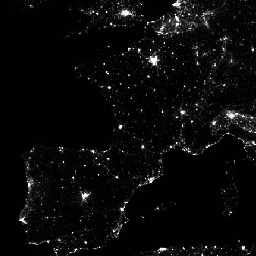
<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">avg_<wbr>rad</code></td>
<td>nanoWatts/cm2/sr</td>
<td>
          -1.5*
</td>
<td>
          193565*
</td>
<td><p>Average DNB radiance values.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">cf_<wbr>cvg</code></td>
<td></td>
<td>
          0*
</td>
<td>
          84*
</td>
<td><p>Cloud-free coverages; <br>the total number of observations that
went into each pixel. <br>This band can be used to identify areas with low
numbers of observations where the quality is reduced.</p></td>
</tr>
</tbody></table>

## Discussion

Please read https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG#description which describes the VIIRS dataset.

Why does it make sense to use the average night radiance to determine whether there is settlement in area? 


# Get the Training data

## Get Features from Sentinel-2 and VIIRS


In [7]:
# Remember this function from Exercise 5_03, what does it do?
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)

In [8]:
lat = -1.9441
lon = 30.0619
offset = 0.51
region = [
        [lon + offset, lat - offset],
        [lon + offset, lat + offset],
        [lon - offset, lat + offset],
        [lon - offset, lat - offset]]

roi = ee.Geometry.Polygon([region])

In [9]:
se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate("2015-07-01","2015-12-31")

# TODO: Use the filterBounds function to get filter the are specified in ROI
se2 = se2.filterBounds(roi)

# Keep pixels that have less than 20% cloud
se2 = se2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20))

# Update the mask 
se2 = se2.map(se2mask)

# Get the median image
se2 = se2.median()

se2 = se2.select(se2bands)

viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).median().select('avg_rad').clip(roi))

# TODO: Read https://developers.google.com/earth-engine/apidocs/ee-image-addbands
# Use the function above to fuse the se2 and viirs bands

fused = se2.addBands(viirs)

## Get Labels from GHSL Dataset

In [10]:
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2).clip(roi)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

In [11]:
data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

In [12]:
data.aggregate_stats(label).getInfo()


{'max': 1,
 'mean': 0.20737724175738115,
 'min': 0,
 'sample_sd': 0.4054439481595326,
 'sample_var': 0.16438479509918977,
 'sum': 2648,
 'sum_sq': 2648,
 'total_count': 12769,
 'total_sd': 0.4054280717445227,
 'total_var': 0.16437192135848186,
 'valid_count': 12769,
 'weight_sum': 12769,
 'weighted_sum': 2648}

## Train-test split
Now that we have gathered our data we would like to split the dataset into training and test sets. We first create a column of random numbers in the range [0, 1] and use that to split the data into training and test sets.

In [13]:
# we'll create a column of random numbers
data = data.randomColumn(seed=0)

We will use a 80/20 train/test split randomly among the pixels in our 2015 training image

In [14]:
split_thresh = 0.8
train = data.filter(ee.Filter.lt('random', split_thresh))
test = data.filter(ee.Filter.gte('random', split_thresh))


In [15]:
train.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.20862186677070127,
 'min': 0,
 'sample_sd': 0.4063433123996777,
 'sample_var': 0.16511488753194206,
 'sum': 2139,
 'sum_sq': 2139,
 'total_count': 10253,
 'total_sd': 0.40632349609124135,
 'total_var': 0.16509878347580903,
 'valid_count': 10253,
 'weight_sum': 10253,
 'weighted_sum': 2139}

In [16]:
test.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.20507887649095807,
 'min': 0,
 'sample_sd': 0.4038369470037715,
 'sample_var': 0.16308427976532694,
 'sum': 533,
 'sum_sq': 533,
 'total_count': 2599,
 'total_sd': 0.4037592486967505,
 'total_var': 0.16302153090816443,
 'valid_count': 2599,
 'weight_sum': 2599,
 'weighted_sum': 533}

## Standardize the Data
Let's see how the results will change if we standardize the data.

In [38]:
# Compute the mean and standard deviation
vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

vmu = ee.Number(vmu.get('avg_rad'))
vstd = ee.Number(vstd.get('avg_rad'))

print(vmu.getInfo())
print(vstd.getInfo())

# Whiten the band
viirsclean = viirs.subtract(vmu).divide(vstd)

# 


0.2062830612359614
1.1950717918110398


In [20]:
fusedclean = se2.addBands(viirsclean)

dataclean = fusedclean.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# we'll create a column of random numbers
dataclean = dataclean.randomColumn(seed=0)


# Training and Prediction outside GEE
In Exercise 5_03 we saw how we can transfer data from GEE to a local setup. Training in a local setup is preferable in most cases.

Deep learning and neural networks are machine-learning techniques that can work well for complex data like satellite imagery. Neither deep learning nor neural networks are supported in GEE's Machine Learning APIs. Instead, to take advantage of them, you will need to use a framework like TensorFlow or PyTorch and train your model outside of Earth Engine.

You may also want to train outside of GEEif you are already familiar with a framework like [scikit-learn](https://scikit-learn.org) for classical machine learning or [XGBoost](https://xgboost.readthedocs.io) for gradient boosted decision trees.

Finally, you may want to train a model outside GEE if your data set is very large and exceeds the limits documented above.

First, let's see the datatype of the `dataclean` datatype.

In [21]:
print(type(dataclean))


<class 'ee.featurecollection.FeatureCollection'>


You can see that the type of `dataclean` is FeatureCollection. Let's now see how we can export the feature collection as CSV so we can use tools such as pandas to load and manipulate the data.

In [22]:
def export_one_table(feature_collection, name):
  """Uses a GEE API to batch transfer data to a GCP project Google Drive"""
  task = ee.batch.Export.table.toDrive(**{
    'collection': feature_collection,
    'description': name,
    'fileFormat': 'CSV'
    })
  task.start()
  while task.active():
    print('Running...')
    # Wait for sometime before showing an update
    time.sleep(100)
  print('Done..', task.status())



In [23]:
name = 'GEEToDrive'
export_one_table(dataclean, name)

Running...
Done.. {'state': 'COMPLETED', 'description': 'GEEToDrive', 'creation_timestamp_ms': 1685458211215, 'update_timestamp_ms': 1685458232942, 'start_timestamp_ms': 1685458215317, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 9.131372451782227, 'id': 'EIWWLQLBOTAXKIRG2Q5XPJBF', 'name': 'projects/earthengine-legacy/operations/EIWWLQLBOTAXKIRG2Q5XPJBF'}


Move the CSV from service account Google Drive to a user user Google Drive.

In [24]:
# Transfer the data from GCP service account drive to current working directory in Colaboratory
gauth = GoogleAuth()
scopes = ['https://www.googleapis.com/auth/drive']
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(".private-key.json", scopes=scopes)

drive = GoogleDrive(gauth)

# get list of files
file_list = drive.ListFile({'q': "trashed=false"}).GetList()
print(f"{len(file_list)} files found")
for file_tiff in file_list:

        filename = file_tiff['title']
        if file_tiff['mimeType'] == 'text/csv':
          # download file into working directory (in this case a tiff-file)
          file_tiff.GetContentFile(filename, mimetype="image/tiff")

          # delete file afterwards to keep the Drive empty
          file_tiff.Delete()

222 files found


## Read the Downloaded CSV

Now that we have the CSV file we can use widely used Python tools such as Pandas, Numpy, and Sci-kit Learn to preprocess the data and train our models.

In [25]:
df = pd.read_csv('GEEToDrive.csv')

In [26]:
df.head()

,system:index,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad,random,smod_code,.geo
0,0_0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,-0.086878,0.028150,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_0,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,-0.070507,0.947643,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2_0,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,-0.089565,0.912751,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3_0,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,-0.093732,0.356224,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4_0,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,-0.050745,0.334730,0,"{""type"":""MultiPoint"",""coordinates"":[]}"


## Sklearn Train Test Split
Similar to what we did from GEE, let's split the dataset into train and test sets. First, let's split the label from the features.

In [27]:
X = df[trainingbands]
X.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad
0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,-0.086878
1,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,-0.070507
2,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,-0.089565
3,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,-0.093732
4,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,-0.050745


In [28]:
y = df[label]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: smod_code, dtype: int64

In [29]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's now create a Random Forest classifier with the parameters we used to train the random forest classifier in GEE.

In [30]:
new_params_sk = {"n_estimators":500, 
              "max_features": "sqrt",
              "min_samples_leaf":1,
              "bootstrap": True,
              "max_samples": 0.5,
              "max_leaf_nodes":None,
              "random_state":42}

In [31]:
clf = RandomForestClassifier(**new_params_sk)

In [32]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5, n_estimators=500, random_state=42)

# Saving the Model to a Pickle File
To deploy the trained model on the Heroku server, you should save it as a pickle file, as shown in the code block below:

First, let's import the `pickle` package.

In [33]:
import pickle



Let's now persist the model to our Colab storage by calling `pickle.dump`.

In [36]:
filename = 'model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(clf, f)

## Download the Saved Model
Download the persisted model by going Files tab on the left pane and downloading the file `model.pkl`.